# Yoga for the Yoga-less
Parker Servello


__Objective:__  
My friend frequently ruminates aloud about his dream of operating a yoga studio. This project will be the first step in making that dream become reality. Since we are going to Denver, Colorado next week, we will work under the assumption that he will fall in love with it and want to settle down there. We will determine the best location for this endeavor by clustering neighborhoods together that typically have yoga studios in them, then choosing an area within that cluster that either has too few or no yoga studios.  

__Data Collection:__  
We will leverage geo-location data for the neighborhoods listed in wikipedia as well as nearby venue data queried from foursquare's API for each neighborhood's coordinates. The clusters will be formed using the venue type frequency for each neighborhood.



In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import folium
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from scipy.spatial.distance import cdist

## Extracting neighborhood geo-data from wikipedia

Get dataframe of neighborhood with their cardinal area and wiki href

In [3]:
page = requests.get(r'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Denver')
soup = BeautifulSoup(page.text, 'lxml')

denver_division = [div.text for div in soup.find_all('span', class_='mw-headline')][:-3]

df = []
for div, lst in zip(denver_division,soup.find_all('ul')[1:11]):
    df.extend([(div, nbhd.text, nbhd['href']) for nbhd in lst.find_all('a')])
    
df = pd.DataFrame(df, columns=['Area','Neighborhood','href'])

df.head()

,Area,Neighborhood,href
0,Central,Baker,"/wiki/Baker,_Denver"
1,Central,Capitol Hill,"/wiki/Capitol_Hill,_Denver"
2,Central,Central Business District,/wiki/Downtown_Denver
3,Central,Cherry Creek,"/wiki/Cherry_Creek,_Denver"
4,Central,Cheesman Park,"/wiki/Cheesman_Park,_Denver"


Now we need to go to each of the hrefs on wikipedia to extract coordinates from the individual neighborhood pages.

In [4]:
lat,lon = [],[]
for href in df['href']:
    
    url = 'https://en.wikipedia.org' + href
    
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'lxml')
    
    try:
        coord = soup.find_all('span', class_='geo')[0].text
        lat.append(coord.split(";")[0])
        lon.append(coord.split(" ")[1])
    
    except:
        lat.append("0")
        lon.append("0")

Add latitude and longitude to dataframe and remove the href column.

In [5]:
df['Latitude'] = list(map(float,lat))
df['Longitude'] = list(map(float,lon))
df.drop('href', axis=1, inplace=True)

Some neighborhoods didn't have a wikipage, so we set their coordinates to 0 to easily filter them out. Let's remove them now.

In [6]:
df = df[df['Latitude'] != 0].reset_index(drop=True)

## Exploring the geo-data

Initially there were 78 neighborhoods. 28 were removed because there is no associated wikipedia page and 6 are removed in the following cell because they are either a park or airport.


In [7]:
df = df[[nbhd not in ['Jefferson Park','Lincoln Park','Villa Park','City Park','Washington Park','Denver International Airport'] for nbhd in df['Neighborhood']]]

df.head()

,Area,Neighborhood,Latitude,Longitude
0,Central,Baker,39.723919,-104.995150
1,Central,Capitol Hill,39.733000,-104.983000
2,Central,Central Business District,39.745870,-104.992819
3,Central,Cherry Creek,39.720967,-104.949804
4,Central,Cheesman Park,39.732780,-104.965830


In [10]:
# create map of Denver using latitude and longitude values
map_denver = folium.Map(location=[39.719, -104.95], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Area'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_denver)  
    
map_denver

Let's remove the airport and parks since they're not relevant to the project.

In [386]:
df = df[[nbhd not in ['Park Hill','Jefferson Park','Lincoln Park','Villa Park','City Park','Washington Park','Denver International Airport','Montbello'] for nbhd in df['Neighborhood']]]

## Requesting data from Foursquare

First, we need to enter credentials from a Foursquare account.

In [427]:
CLIENT_ID = 'my_id'
CLIENT_SECRET = 'my_secret'
VERSION = '20180605'

Now we can request the data.

Creating a function that extracts the nearby venues

In [388]:
def get_nearby_venues(names, latitudes, longitudes, radius=1000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,  CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [389]:
denver_venues = get_nearby_venues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [393]:
print('There are {} uniques categories and {} unique venues.'.format(len(denver_venues['Venue Category'].unique()),len(denver_venues['Venue'].unique())))

There are 275 uniques categories and 1681 unique venues.


One hot encoding

In [394]:
# one hot encoding
denver_onehot = pd.get_dummies(denver_venues[['Venue Category']], prefix="", prefix_sep="")
denver_onehot = denver_onehot.iloc[:,list(denver_onehot.sum()>11)]

# add neighborhood column back to dataframe
denver_onehot['Neighborhood'] = denver_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [denver_onehot.columns[-1]] + list(denver_onehot.columns[:-1])
denver_onehot = denver_onehot[fixed_columns]

Standardizing the data for clustering

In [395]:
denver_grouped_means = denver_onehot.groupby('Neighborhood').mean().reset_index()
denver_grouped_clustering = denver_grouped_means.drop('Neighborhood', 1)

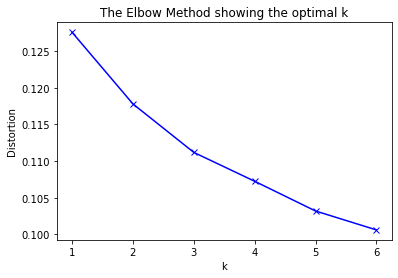

In [398]:
 # clustering dataset
# determine k using elbow method

# k means determine k
distortions = []
K = range(1,7)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(denver_grouped_clustering)
    kmeanModel.fit(denver_grouped_clustering)
    distortions.append(sum(np.min(cdist(denver_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / denver_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


From the elbow method, we see that we should use 3 clusters.

In [406]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=40).fit(denver_grouped_clustering)

# get the count of each venue category instance by neighborhood
denver_grouped_sums = denver_onehot.groupby('Neighborhood').sum().reset_index()
denver_grouped_sums['Cluster'] = kmeans.labels_

# find the average number of each venue category per cluster
venue_clusters = denver_grouped_sums.groupby('Cluster').mean()
venue_clusters = venue_clusters.T



In [407]:
# create dataframe of neighborhood coordinates and clusters
denver_merged = df[[nbhd in set(denver_venues['Neighborhood']) for nbhd in df['Neighborhood']]]
denver_merged = denver_merged.merge(denver_grouped_sums[['Neighborhood','Cluster']])

In [408]:
# create map
map_clusters = folium.Map(location=[39.719, -104.95], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(denver_merged['Latitude'], denver_merged['Longitude'], denver_merged['Neighborhood'], denver_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Find the cluster where the average neighborhood has at least one yoga studio.  

In [410]:
venue_clusters[venue_clusters.columns[venue_clusters.loc['Yoga Studio']>1]].loc['Yoga Studio']

Cluster
2    1.3
Name: Yoga Studio, dtype: float64

Cluster 2 has an average of 1.3 yoga studios per neighborhood.

Are there any neighborhoods in cluster 2 that do not have a yoga studio in them? If so, we should open one there!

In [403]:
solution = list(denver_grouped_sums[(denver_grouped_sums['Yoga Studio']==0) & (denver_grouped_sums['Cluster']==2)]['Neighborhood'])
solution

['Auraria', 'Central Business District', 'LoDo', 'Union Station']

Let's see the the area where we are going to set up the new yoga studio.

In [423]:
# create map of Denver using latitude and longitude values
map_denver = folium.Map(location=[39.75, -104.998], zoom_start=14)

df_solution = df[[nbhd in solution for nbhd in df['Neighborhood']]]

# add markers to map
for lat, lng, borough, neighborhood in zip(df_solution['Latitude'], df_solution['Longitude'], df_solution['Area'], df_solution['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_denver)  
    
map_denver

This is right on the University of Colorado campus!  

My friend also wants to be a professor. Maybe he could teach at the university while he runs his yoga studio.